### increase ram size if required

In [ ]:
i = []
while True:
  i.append(i)

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

2.4.1


### get list of top 40 features based on t-test

In [ ]:
t_statistic_array = np.abs(np.genfromtxt("/content/drive/MyDrive/Thesis/files/no_background/t_statistic_array.csv", delimiter=','))
ttest_df = pd.DataFrame(data=t_statistic_array, columns=['ttest_val'])
ttest_df.ttest_val = np.abs(ttest_df.ttest_val.values)
ttest_df.insert(loc=0, column='band_no', value=np.arange(186))

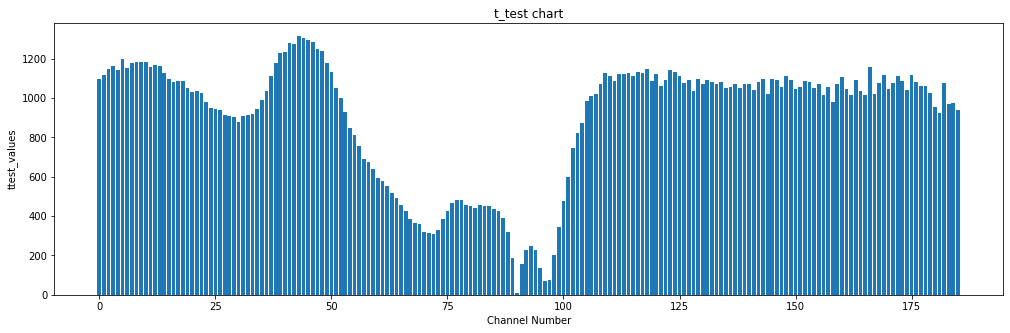

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values)
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
# plt.savefig('/content/drive/MyDrive/Thesis/images/normalized/no_background/LR/' + 'ttest_normalized' + '.png')
plt.show() 

In [ ]:
sorted_ttest_df = ttest_df.sort_values(ascending=False, by='ttest_val')

In [ ]:
top_selected = sorted_ttest_df.iloc[:40,:]

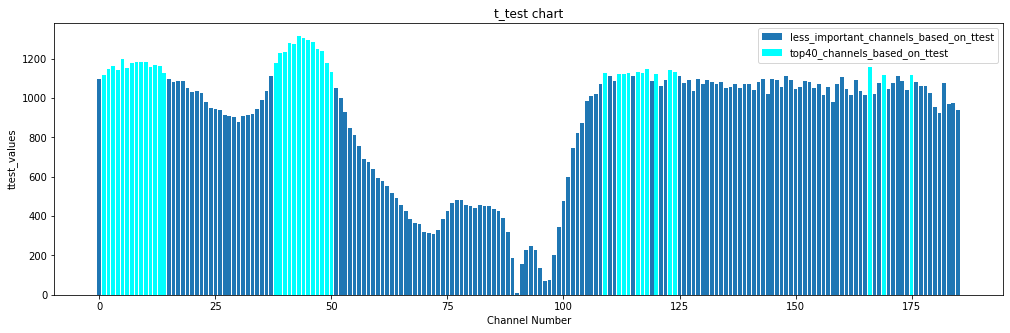

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ttest_df.band_no.values, ttest_df.ttest_val.values, label='less_important_channels_based_on_ttest')
plt.bar(top_selected.band_no.values, top_selected.ttest_val.values, color='cyan', label='top40_channels_based_on_ttest')
plt.xlabel('Channel Number')
plt.ylabel('ttest_values')
plt.title('t_test chart')
plt.legend(loc='upper right')
# plt.savefig('/content/drive/MyDrive/Thesis/images/normalized/no_background/LR/' + 'top40_ttest_normalized_no_background' + '.png')
plt.show() 

### load selected channels for training

In [ ]:
bands_list = top_selected.band_no.values

In [ ]:
bands_list

array([ 43,  44,  45,  46,  41,  42,  47,  48,  40,  39,   5,   9,  10,
         8,  38,   7,  49,  12,   3,  13, 166,  11,   6, 118,   2,   4,
       123, 124, 116,  50, 109, 114,  14, 117, 113, 120, 112, 169,   1,
       175])

In [ ]:
y = np.load('/content/drive/MyDrive/Thesis/segmented_bands/label.npy')

In [ ]:
y.shape

(8410045,)

In [ ]:
X = np.zeros((8410045, 40), dtype='float32')

In [ ]:
for i in range(len(bands_list)):
  X[:, i:i+1] = np.load('/content/drive/MyDrive/Thesis/segmented_bands/band_' + str(bands_list[i]) + '.npy').reshape(-1, 1)
  print(i)

In [ ]:
# using numpy =====================================
# X = np.concatenate((X, y), axis=1)
# np.random.shuffle(X)
# y = X[:, 50:]
# X = np.delete(X, 50, 1)

In [ ]:
df = pd.DataFrame(data=X)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.080748,0.081628,0.082246,0.082209,0.082994,0.081314,0.085431,0.083697,0.080989,0.081016,0.073905,0.056552,0.062749,0.060123,0.074765,0.062921,0.085600,0.059066,0.062560,0.066134,0.284609,0.059414,0.055737,0.200913,0.071277,0.062931,0.211861,0.210896,0.199281,0.085764,0.193743,0.196735,0.064663,0.198488,0.195890,0.203392,0.195848,0.271737,0.055364,0.293130
1,0.094785,0.093623,0.097864,0.098773,0.092296,0.094340,0.099247,0.100791,0.091789,0.082082,0.062005,0.064419,0.063158,0.061098,0.084942,0.056494,0.097506,0.062476,0.059053,0.054707,0.326965,0.051043,0.055613,0.268123,0.058796,0.048920,0.270552,0.277620,0.262482,0.101604,0.254955,0.259298,0.055160,0.264362,0.256119,0.270898,0.256110,0.337200,0.071298,0.342472
2,0.092634,0.090981,0.092011,0.093833,0.089847,0.093519,0.097458,0.094397,0.092310,0.089588,0.060415,0.065689,0.063281,0.054036,0.087074,0.059265,0.095819,0.056630,0.054795,0.062356,0.310785,0.055753,0.061075,0.250791,0.045807,0.055062,0.256087,0.254455,0.248540,0.098819,0.238980,0.243044,0.071907,0.245912,0.240436,0.252370,0.242744,0.325962,0.043482,0.327869


In [ ]:
df.insert(0, "label", value=np.array(y, dtype=int), allow_duplicates=True)

In [ ]:
df = df.sample(frac = 1)
df.head(3)

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
700140,1,0.084975,0.087776,0.083549,0.086385,0.082325,0.088286,0.086695,0.087743,0.082818,0.087912,0.085637,0.071125,0.071407,0.068774,0.081129,0.072117,0.088883,0.081089,0.076670,0.068954,0.487430,0.069952,0.081757,0.483044,0.082645,0.080342,0.491733,0.485602,0.483638,0.090581,0.482649,0.490003,0.077062,0.494047,0.487821,0.492995,0.486369,0.481623,0.085778,0.466268
8297149,0,0.192702,0.200854,0.204203,0.200365,0.183293,0.183203,0.205694,0.208118,0.175464,0.163791,0.050981,0.046007,0.046738,0.055958,0.147730,0.056606,0.201470,0.051341,0.051147,0.045245,0.413389,0.050119,0.047243,0.440536,0.040974,0.054395,0.447890,0.446468,0.445963,0.200111,0.445408,0.455932,0.042681,0.449317,0.443102,0.447064,0.441245,0.414518,0.072347,0.414072
3430141,0,0.146417,0.140903,0.146958,0.153840,0.135042,0.136614,0.156644,0.156625,0.129507,0.123562,0.041466,0.034652,0.039814,0.042392,0.114508,0.036563,0.160911,0.035321,0.060152,0.029388,0.431400,0.039726,0.041521,0.436624,0.030723,0.037170,0.426990,0.434417,0.438668,0.155599,0.431726,0.434029,0.034472,0.427490,0.429271,0.427360,0.424795,0.427509,0.037478,0.426143


In [ ]:
X = df.iloc[:, 1:]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40/dataset.npy', X)

In [ ]:
y = df.iloc[:, 0:1]

In [ ]:
# np.save('/content/drive/MyDrive/Thesis/shuffled_top40/label.npy', y)

In [ ]:
# y = np.load('/content/drive/MyDrive/Thesis/shuffled_top40/label.npy')

In [ ]:
# X = np.load('/content/drive/MyDrive/Thesis/shuffled_top40/dataset.npy')

### logistic regression using keras

start preparing dataset

In [ ]:
input_shape = [X.shape[1],]
input_shape

[40]

In [ ]:
band_normalizer = preprocessing.Normalization(input_shape=input_shape)

In [ ]:
# bands = np.array(X)

In [ ]:
band_normalizer.adapt(np.array(X))

In [ ]:
model = tf.keras.Sequential([
    band_normalizer,
    layers.Dense(units=1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40)                81        
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 122
Trainable params: 41
Non-trainable params: 81
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=3)

In [ ]:
%%time
history = model.fit(
    X, y,
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 25% of the training data
    validation_split = 0.25,
    callbacks=[callback]
    )

Epoch 1/100
197111/197111 [==============================] - 504s 3ms/step - loss: 0.4114 - accuracy: 0.8311 - val_loss: 0.3857 - val_accuracy: 0.8385
Epoch 2/100
197111/197111 [==============================] - 524s 3ms/step - loss: 0.4094 - accuracy: 0.8329 - val_loss: 0.4564 - val_accuracy: 0.8068
Epoch 3/100
197111/197111 [==============================] - 506s 3ms/step - loss: 0.4101 - accuracy: 0.8327 - val_loss: 0.4004 - val_accuracy: 0.8255
Epoch 4/100
197111/197111 [==============================] - 515s 3ms/step - loss: 0.4101 - accuracy: 0.8326 - val_loss: 0.3795 - val_accuracy: 0.8467
CPU times: user 40min, sys: 7min 32s, total: 47min 32s
Wall time: 34min 9s


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.410023,0.832448,0.385663,0.838519,0
1,0.409838,0.832613,0.456354,0.806801,1
2,0.409925,0.832628,0.400411,0.825494,2
3,0.409666,0.832609,0.379524,0.846710,3


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 5])
  plt.xlabel('Epoch')
  plt.ylabel('error')
  plt.legend()
  plt.grid(True)

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

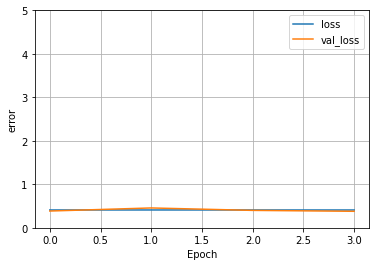

In [ ]:
plot_loss(history)

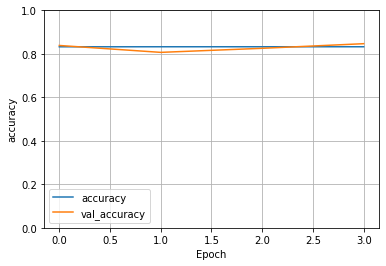

In [ ]:
plot_accuracy(history)

In [ ]:
# # save model
# model.save('/content/drive/MyDrive/Thesis/models/LR_normalized_top40_ttest_nobackground')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Thesis/models/LR_normalized_top40_ttest_nobackground/assets


In [ ]:
# # load model
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/Thesis/models/LR_normalized_top40_ttest_nobackground')

In [ ]:
# predict = model.predict(X)
# accuracy_score(np.round(predict), y[:])

## test model on mean values dataset

In [ ]:
columns = np.array(np.arange(186) + 1, dtype='int')

In [ ]:
# getting list of cropped reference images
source_file = '/content/drive/MyDrive/Thesis/source/VNIR_img.txt'
img_list = []
with open(source_file, "r") as listOfImages:
    for line in listOfImages:
        to_lower = str(line.strip()).lower() # make lower case to match reference imgs name
        img_list.append(to_lower)
        
print(len(img_list))

12


In [ ]:
ref = pd.read_csv('/content/drive/MyDrive/Thesis/files/img_labels.csv', encoding='latin-1')
ref.insert(loc=1, column='ref', value=img_list)
ref.head(3)

,Img_name,ref,PCR
0,Ind-AT1_V1-A_Blatt_VNIR,ind-at1_v1-a_blatt_vnir,1
1,Ind-AT1_V1-B_Blatt_VNIR,ind-at1_v1-b_blatt_vnir,1
2,Ind-AT1_V1-C_Blatt_VNIR,ind-at1_v1-c_blatt_vnir,1


In [ ]:
img = np.load('/content/drive/MyDrive/Thesis/cropped_imgs/'+ ref.Img_name[0] +'.npy')

In [ ]:
img.shape

(2270, 1270, 186)

In [ ]:
df = pd.DataFrame(data=img.reshape(-1, 186), columns=columns)

In [ ]:
band_list = np.array([ 43,  44,  45,  46,  41,  42,  47,  48,  40,  39,   5,   9,  10, 
                      8,  38,   7,  49,  12,   3,  13, 166,  11,   6, 118,   2,   4,
                      123, 124, 116,  50, 109, 114,  14, 117, 113, 120, 112, 169, 1, 175])

In [ ]:
for i in band_list:
  img[:, :, i:i+1].reshape(-1, 1)
  print(i)

### Logistic Regression using sklearn

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression(penalty='none' ,random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
predict = clf.predict(X_test)

In [ ]:
accuracy_score(predict, y_test)

0.8502924121241638

In [ ]:
print(classification_report(predict, y_test))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87   1229505
           1       0.81      0.84      0.82    873007

    accuracy                           0.85   2102512
   macro avg       0.85      0.85      0.85   2102512
weighted avg       0.85      0.85      0.85   2102512



In [ ]:
precision_recall_curve(y_test, predict)

(array([0.43335639, 0.8415637 , 1.        ]),
 array([1.        , 0.80634526, 0.        ]),
 array([0, 1]))

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

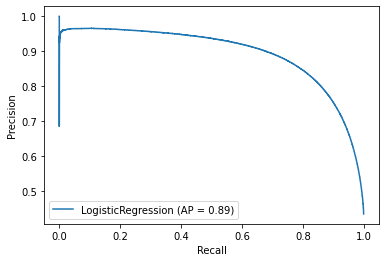

In [ ]:
disp = plot_precision_recall_curve(clf, X_test, y_test)

### LDA using sklearn

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
clf = lda.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
predict = clf.predict(X_test)

In [ ]:
clf.explained_variance_ratio_

array([1.])

In [ ]:
accuracy_score(y_test, predict)

0.8514714779273554

In [ ]:
print(classification_report(y_test, predict, target_names=['Pos', 'Neg']))

              precision    recall  f1-score   support

         Pos       0.86      0.89      0.87   1191532
         Neg       0.85      0.80      0.82    910980

    accuracy                           0.85   2102512
   macro avg       0.85      0.85      0.85   2102512
weighted avg       0.85      0.85      0.85   2102512



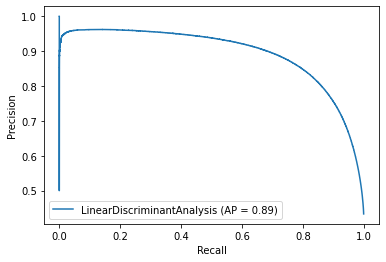

In [ ]:
disp = plot_precision_recall_curve(clf, X_test, y_test)

### RF usnig sklearn

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
clf = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [ ]:
predict = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, predict, target_names=['Pos', 'Neg']))

In [ ]:
disp = plot_precision_recall_curve(clf, X_test, y_test)

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

In [ ]:
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.linear_model import Ridge

In [ ]:
X, y = load_iris(return_X_y=True)

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)

In [ ]:
valid_scores

array([[0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667],
       [0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667],
       [0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ]])

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)